## Gradient optimization for liquid chromatography

In this notebook, we aim to optimize of liquid chromatography gradients using DeepLC[1][2] predictions. Our objective is to refine the separation of peptides by adjusting the acetonitrile (ACN) gradient based on predicted ACN%. The first step involves loading our dataset, predicted_acn_court.csv, which contains peptide information and their respective predicted ACN% by DeepLC.

[1] Bouwmeester, R.; Gabriels, R.; Hulstaert, N.; Martens, L.; Degroeve, S. DeepLC Can Predict Retention Times for Peptides That Carry As-yet Unseen Modifications. Nat Methods 2021, 18 (11), 1363–1369. https://doi.org/10.1038/s41592-021-01301-5.

[2] RobbinBouwmeester/LC_gradient_predict. https://github.com/RobbinBouwmeester/LC_gradient_predict/tree/main (accessed 2024-03-27).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Loading the data which is the output of DeepLC gradient predict
filename = 'predicted_acn_court.csv'
df = pd.read_csv(filename)

df = df.sort_values(by='perc_b') # sorted by increasing perc_b
print(df.head())

             seq         tr modifications  uncal_preds     perc_b  project
0       STMKPVQK   8.511226        O (M3)     3.596018   9.402841        1
1        KLEDGPK   9.854111           NaN     3.664103   9.777621        1
3  EYHPDKNPNAGDK  11.155799           NaN     3.725743  10.116925        1
2  AAGHPGDPESQQR  10.687922           NaN     3.726865  10.123104        1
7  HVAVTNMNEHSSR  11.373624        O (M7)     3.772557  10.374620        1


For targeted analysis, we filter peptides that fall within a specific ACN percentage range (20-25%). This selection is based on our interest in peptides within this range, allowing for a more focused optimization.

In [ ]:

# here we filter the DataFrame to select peptides having specific %ACN in order to better seperate them (in a case where certain peptides interest us)
#let's say peptides between 20 and 25% are interesting to us and we want to better seperate them
df_filtered = df[(df['perc_b'] >= 20) & (df['perc_b'] <= 25)]


perc_b_between_20_and_25 = df_filtered['perc_b']
a= perc_b_between_20_and_25.index[0]
b=perc_b_between_20_and_25.index[-1]
# in a and b we stored the indexes of the peptides that interest us


Using the platypus-opt library, we set up a multi-objective optimization problem aiming to find a Pareto-optimal set of solutions.

These solutions seek to balance the overall distribution quality of retention times (RT) and the specific RT distribution within the selected ACN% range.

Multi-objective optimization helps in finding a set of Pareto-optimal solutions, where no objective can be improved without worsening at least one other objective. This means achieving a balance between overall RT distribution quality and specific performance within the selected range.

In [ ]:
!pip install platypus-opt
import numpy as np
from platypus import Problem, Real

class RTProblem(Problem):
    def __init__(self, dim):
        super(RTProblem, self).__init__(dim, 2)  # dim variables, 2 objectives
        self.types[:] = [Real(6, 50) for _ in range(dim)]  # bound each variable between 6 and 50 (minutes)

    def evaluate(self, solution):
        rts = np.sort(solution.variables) # the fitness evaluation sorts rts in increasing order to optimize
        diffs = np.diff(rts)

        # Objective 1:  the sum of differences
        sum_of_differences =np.sum(diffs)

        # Objective 2: Optimize the spacing between a and b ( peptides in which we are interested, the selected range)
        selected_rts = rts[a:b] # optimizing between a and b
        desired_spacing_min = 0.05
        desired_spacing_max = 5
        optimal_spacing_score = -sum(1 for diff in np.diff(selected_rts) if desired_spacing_min <= diff <= desired_spacing_max)

        solution.objectives[:] = [sum_of_differences, optimal_spacing_score]
from platypus import NSGAII

dim = len(df['perc_b'])
problem = RTProblem(dim)

algorithm = NSGAII(problem, population_size=1000)

generations = 100000
algorithm.run(generations)


import matplotlib.pyplot as plt


objectives = np.array([s.objectives[:] for s in algorithm.result])




## Plotting the Pareto-optimal Front

Each point on the curve represents a unique gradient profile evaluated by the algorithm. The front exhibits the trade-off between the two objectives: global separation efficiency and specific peptide separation. The descent along the front indicates that improvements in specific peptide separation often result in compromises in global separation.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


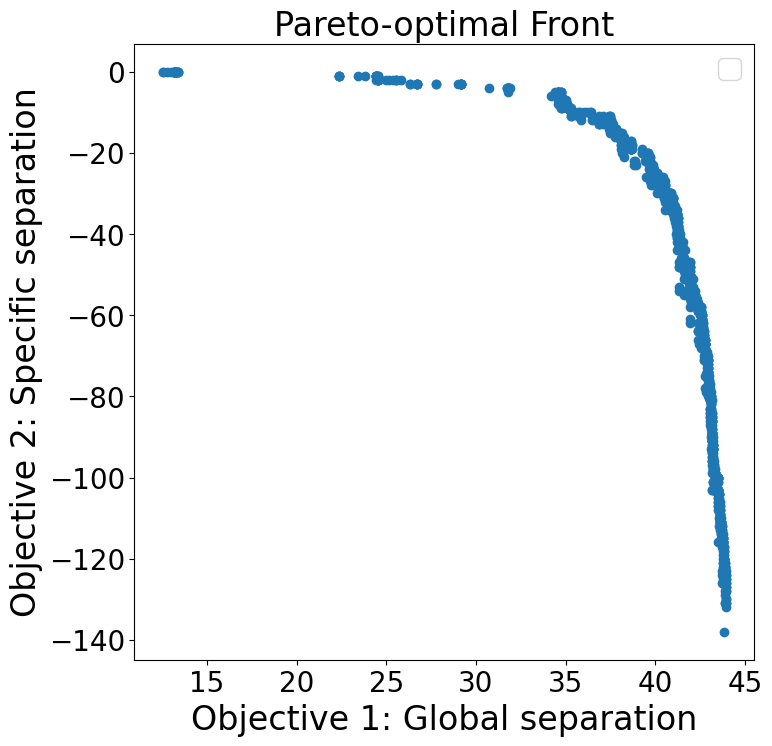

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(objectives[:, 0], objectives[:, 1])
plt.xlabel('Objective 1: Global separation', fontsize=24)
plt.ylabel('Objective 2: Specific separation', fontsize=24)
plt.title('Pareto-optimal Front', fontsize=24)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.legend(fontsize=20)
plt.show()



## Plotting the desired optimal gradient

In [ ]:
#Let's sort the pareto front by the second objective (specific separation) so we can later plot the best solution according to the second objective
pareto_front = objectives
pareto_front_sorted = pareto_front[pareto_front[:, 1].argsort()]

print(pareto_front_sorted)


[[  43.84023762 -138.        ]
 [  43.93256427 -132.        ]
 [  43.88904113 -131.        ]
 ...
 [  13.39718306    0.        ]
 [  13.28601074    0.        ]
 [  12.52774934    0.        ]]


We will plot the best solution for the objective 2.

In [ ]:

gradient = pareto_front_sorted[0]


knee_solution_variables = algorithm.result[np.where(np.all(objectives ==gradient, axis=1))[0][0]].variables


df_sorted_by_perc_b = df.sort_values(by='perc_b').reset_index(drop=True)
perc_b_values = df_sorted_by_perc_b['perc_b'].values


knee_solution_variables = np.sort(knee_solution_variables)





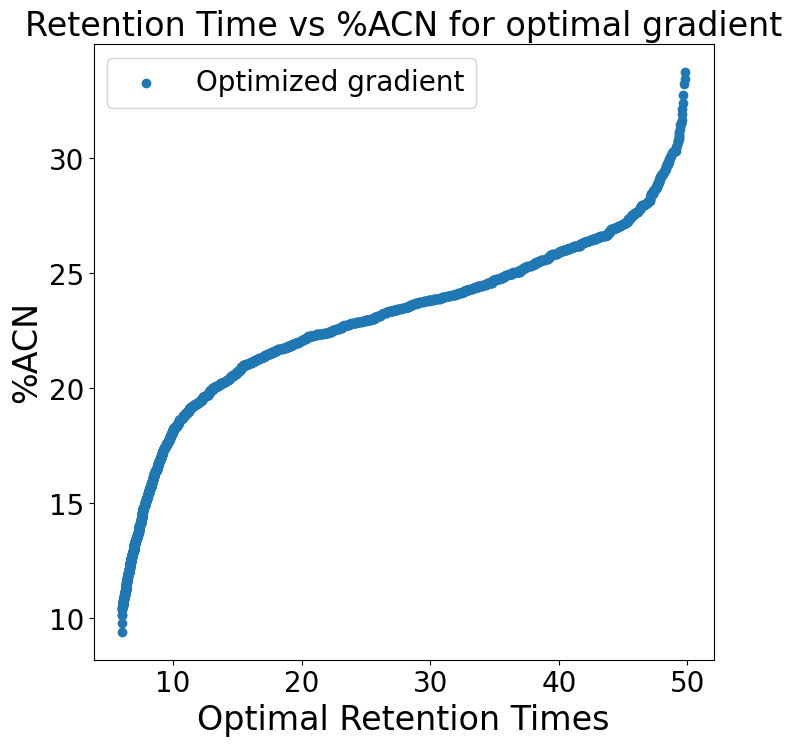

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(knee_solution_variables, perc_b_values[:len(knee_solution_variables)], label="Optimized gradient")
plt.xlabel('Optimal Retention Times',fontsize=24)
plt.ylabel('%ACN',fontsize=24)
plt.title('Retention Time vs %ACN for optimal gradient',fontsize=24)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.legend(fontsize=20)
plt.show()


 To further refine our results, we will represent this gradient in linear intervals, aiding in the practical application of our findings.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


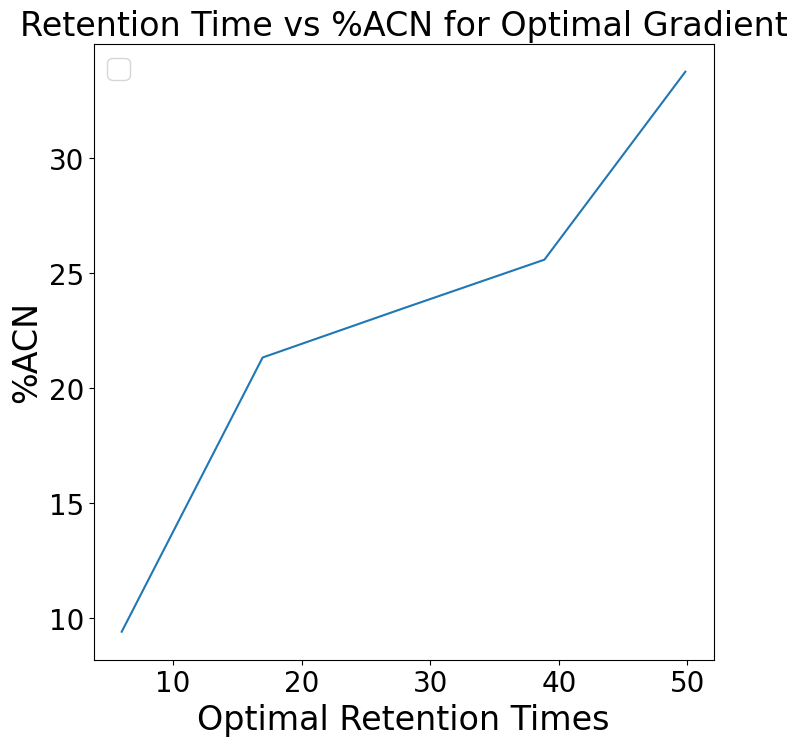

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


x = np.array(knee_solution_variables).flatten()
y = np.array(df['perc_b'][:len(knee_solution_variables)]).flatten()


xnew = np.linspace(np.min(x), np.max(x), num=5)
ynew = np.interp(xnew, x, y)


plt.figure(figsize=(8, 8))
plt.plot(xnew, ynew, '-')

plt.xlabel('Optimal Retention Times', fontsize=24)
plt.ylabel('%ACN', fontsize=24)
plt.title('Retention Time vs %ACN for Optimal Gradient', fontsize=24)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20)
plt.show()
